# Methods
- hta 2.0 array processed data was downloaded from exon.ucsc.edu. Significant events were described using a q-value cutoff of 0.05. Inclusion sepscore cutoffs of 0.5 and -0.5 were used to describe splicing inclusion, exclusion, and unchanged events. Additionally, complex events (instances where an event is multiply classified) and events which lie on noncanonical chromosomes were filtered. 
- To classify 'weak', 'medium', and 'strongly' spliced events, absolute sepscore cutoffs of 0.5 < 1, 1 < 1.5, and 1.5+ were used. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import copy
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

# Figure 3b - Cassette Exon Behavior

In [2]:
date = "3-10-2017"
exon_or_event = "exon" # if "exon", we're using the inclredo.csv, since that file contains the cassette exon. This file also only contains cassettes.

sep_score_threshold = 0.5
p_val_threshold = 0.05
# all_data = '/home/bay001/projects/tbos_splicing_20160203/permanent_data/all_tbos_data.csv' # downloaded from exon.ucsc.edu ## REPLACED WITH INCLREDO.CSV
# event_cols = ['Gene','path','event position','event name','notes'] # if downloading from exon.ucsc.edu
event_cols = ['chrom','exon_start','exon_end','nice_name','0','strand','uniq_name','Gene','path','event position','event name','notes']
all_data = '/projects/ps-yeolab3/bay001/tbos/inclredo.csv' # formerly /home/bay001/projects/tbos_splicing_20160203/permanent_data/inclredo.csv
event_centric_dir = '/home/bay001/projects/tbos_splicing_20160203/data/temp/{}'.format(date)
exon_centric_dir = '/home/bay001/projects/tbos_splicing_20160203/data/temp/{}'.format(date)


if not os.path.exists(event_centric_dir):
    ! mkdir $event_centric_dir
if not os.path.exists(exon_centric_dir):
    ! mkdir $exon_centric_dir

In [3]:
df = pd.read_table(all_data)

/home/bay001/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Filter out all the extra stuff, just want q-value, position, and sepscore
def filter_out_weird_chroms_and_unimportant_cols(df, col_prefix='hta_sepscore_yeo_aug15_all_', event_cols=event_cols):
    df = df[df['event position'].str.contains('chr[XY\d]+\:')==True] # remove noncanonical chromosomes (chr6_hap etc.)
    df = df[df['notes']!='complex '] # remove 'complex' events from the equation
    df['notes'] = df['notes'].replace(' ','') # removes that annoying extra space that is in the notes section.
    print("num events: ",df.shape[0])
    dfx = df.filter(regex=("^hta_sepscore"))
    conditions = [] # the conditions (apobec4_over, apobec4_kd, etc.)
    cols_to_keep = copy.copy(event_cols) # keep only the columns with the above prefix (grab all cols if col_prefix is none)

    for column in dfx.columns:
        if column.endswith("_sepscore"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)

        elif column.endswith("_q-value"):
            if(column.startswith(col_prefix)):
                cols_to_keep.append(column)
                conditions.append(
                    column.replace('_q-value','').replace('hta_sepscore_yeo_aug15_all_','')
                )
    df = df[cols_to_keep]
    return conditions, df

def build_sepscore_dict(conditions, df, col_prefix='hta_sepscore_yeo_aug15_all_'):
    # Further separate by individual condition (apobec4_over, apobec4_kd, etc.)
    scores = {}
    y = tnrange(len(conditions))
    for condition in conditions:
        cols_to_keep = copy.copy(event_cols)
        sepscore_col = col_prefix + condition + '_sepscore'
        qvalue_col = col_prefix + condition + '_q-value'
        cols_to_keep.append(sepscore_col)
        cols_to_keep.append(qvalue_col)
        df[qvalue_col].fillna(1,inplace=True) # fill p-value nans with 1
        df[sepscore_col].fillna(0,inplace=True) # fill sepscore nans with 0

        included = df[
            (df[qvalue_col] < p_val_threshold) & (df[sepscore_col] > sep_score_threshold)
        ]
        included = included[cols_to_keep]

        excluded = df[
            (df[qvalue_col] < p_val_threshold) & (df[sepscore_col] < -sep_score_threshold)
        ]
        excluded = excluded[cols_to_keep]

        unchanged = df[
            (df[qvalue_col] < p_val_threshold) & 
            (df[sepscore_col] >= -sep_score_threshold) & 
            (df[sepscore_col] <= sep_score_threshold)
        ]
        unchanged = unchanged[cols_to_keep]

        scores[condition] = {
            'included':included,
            'excluded':excluded,
            'unchanged':unchanged
        }
        y.update(1)
    return scores

In [5]:
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df)
scores = build_sepscore_dict(conditions, df)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


('num events: ', 8046)



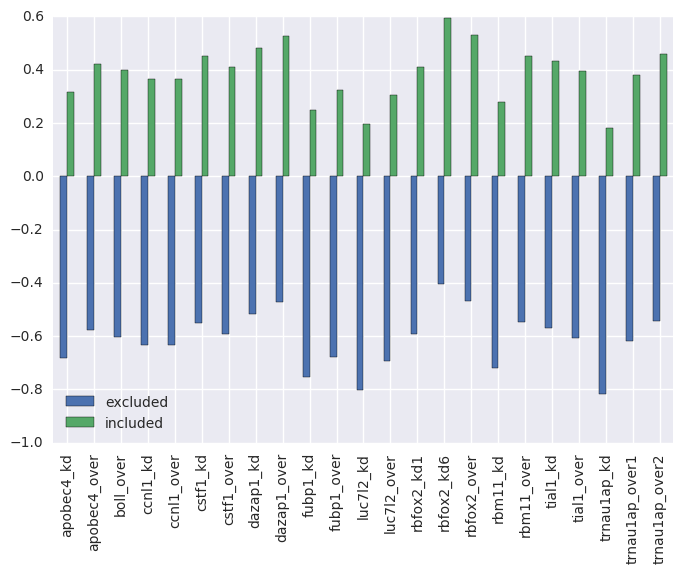

In [6]:
# num significant events:
strength = defaultdict(dict)

for condition in sorted(scores.keys()):
    included_num = scores[condition]['included'].shape[0]
    excluded_num = scores[condition]['excluded'].shape[0]
    total_num = scores[condition]['included'].shape[0]+scores[condition]['excluded'].shape[0]
    strength[condition] = {
        'included':included_num/float(total_num),
        'excluded':-excluded_num/float(total_num),
    }
pd.DataFrame(strength).T.plot(kind='bar')

# Export sepscores as MISO-like events

In [7]:
MIN_CHROM = 1
MAX_CHROM = 300000000
y = tnrange(len(conditions))

def to_miso(row):
    chrom,pos,strand = row['event position'].split(':')
    pos1, pos2 = pos.split('-')
    
    if(strand == '-'):
        upstart = int(pos2) + 1
        upend = MAX_CHROM
        downstart = MIN_CHROM
        downend = pos1
    else:
        upstart = MIN_CHROM
        upend = pos1
        downstart = int(pos2) + 1
        downend = MAX_CHROM
    skipstart = int(row['exon_start']) + 1
    skipend = row['exon_end']
    return '{}:{}:{}:{}@{}:{}:{}:{}@{}:{}:{}:{}'.format(
    chrom,upstart,upend,strand,
    chrom,skipstart,skipend,strand,
    chrom,downstart,downend,strand)

for condition in sorted(scores.keys()):
    y.update(1)
    for sep_kind in ['included','excluded','unchanged']:
        df = scores[condition][sep_kind].copy()
        df['miso_string'] = df.apply(to_miso, axis=1)
        dfx = pd.concat([df['miso_string'],df['uniq_name']],axis=1)
        out_file = os.path.join(
            exon_centric_dir,"{}.{}.sep_{}.p_{}.tsv".format(
                condition, sep_kind, sep_score_threshold, p_val_threshold
            )
        )
        dfx.to_csv(out_file,sep='\t',index=None,header=None)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


# Figure 3b - % Total Events

In [8]:
all_data = '/home/bay001/projects/tbos_splicing_20160203/permanent_data/all_tbos_data.csv' # downloaded from exon.ucsc.edu ## REPLACED WITH INCLREDO.CSV
event_cols = ['Gene','path','event position','event name','notes'] # if downloading from exon.ucsc.edu

In [9]:
df = pd.read_table(all_data)
df = df[df['path']=='in'] # avoid double counting the 'sk' and 'in' for the same event.
print("num events: ",df.shape[0])

/home/bay001/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,11,12,18,19,25,26,32,33,40,47,54,61,68,75,82,89,96,103,110,117,124,131,138,145,152,208) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


('num events: ', 29653)


In [10]:
scores['trnau1ap_kd']['excluded']['notes'].value_counts().add(scores['trnau1ap_kd']['included']['notes'].value_counts(), fill_value=0)

alt_cassette     352
Name: notes, dtype: int64

In [11]:
conditions, df = filter_out_weird_chroms_and_unimportant_cols(df)
scores = build_sepscore_dict(conditions, df)

('num events: ', 26310)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [12]:
merged = pd.DataFrame()
for condition in conditions:
    total_significant_events = \
        scores[condition]['included']['notes'].value_counts().add(
            scores[condition]['excluded']['notes'].value_counts(),
            fill_value=0
        )
        
    total_significant_events = pd.DataFrame(total_significant_events)
    total_significant_events.columns = [condition]
    merged = pd.merge(merged, total_significant_events, how='outer', left_index=True, right_index=True).fillna(0)

merged

,dazap1_over,rbfox2_over,tial1_over,luc7l2_over,rbfox2_kd6,cstf1_over,rbm11_kd,dazap1_kd,trnau1ap_over2,apobec4_over,...,boll_over,ccnl1_kd,tial1_kd,trnau1ap_over1,rbm11_over,rbfox2_kd1,apobec4_kd,fubp1_kd,trnau1ap_kd,luc7l2_kd
alt_3,96,32.0,256,49,177,92,59.0,220,74.0,308,...,332,69.0,128,259,110.0,145,418,55,65.0,127
alt_5,78,29.0,194,23,141,77,34.0,176,46.0,233,...,259,60.0,117,239,78.0,105,385,37,56.0,132
alt_cassette,720,98.0,1140,121,871,306,226.0,1218,223.0,1387,...,1530,337.0,688,1355,316.0,635,2273,327,352.0,831
alt_end,211,11.0,479,42,229,104,62.0,563,73.0,576,...,697,91.0,172,589,99.0,154,1153,74,125.0,261
alt_start,103,31.0,363,47,239,143,57.0,340,101.0,455,...,620,62.0,127,493,157.0,198,789,54,85.0,150
mutually_exc,6,0.0,11,2,10,4,1.0,7,1.0,13,...,10,0.0,3,9,2.0,8,20,3,1.0,6
retained_int,173,67.0,423,48,269,245,113.0,318,148.0,504,...,617,148.0,157,506,227.0,184,719,78,135.0,192
twin_cassett,26,5.0,42,6,36,11,7.0,42,8.0,56,...,69,7.0,19,56,17.0,24,78,8,11.0,29


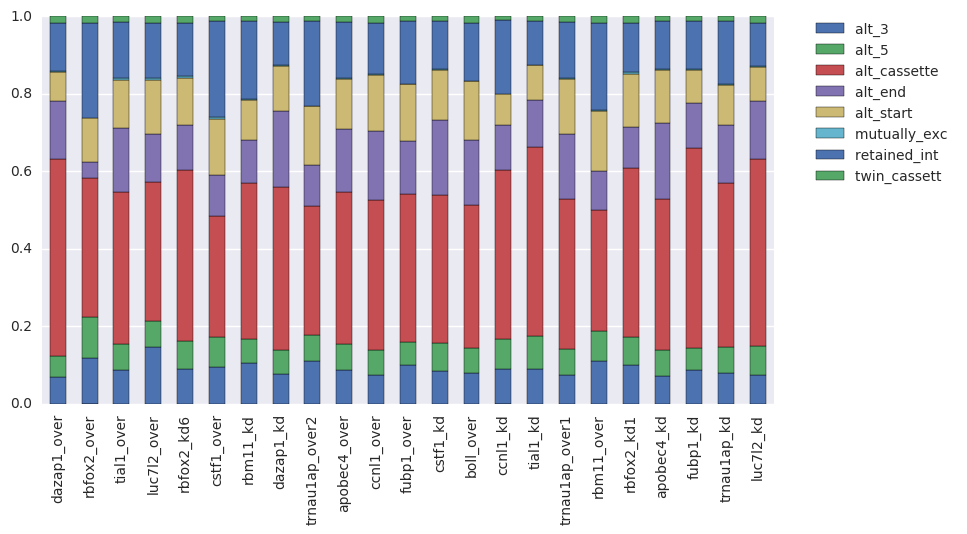

In [13]:
merged.div(merged.sum()).T.plot(kind='bar',stacked=True,legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# Get the overlap between KD and OVER sepscore events

In [14]:
over_to_kd = {
    'dazap1_over':'dazap1_kd',
    'rbfox2_over':'rbfox2_kd1',
    'tial1_over':'tial1_kd',
    'luc7l2_over':'luc7l2_kd',
    'cstf1_over':'cstf1_kd',
    'rbm11_over':'rbm11_kd',
    'apobec4_over':'apobec4_kd',
    'ccnl1_over':'ccnl1_kd',
    'trnau1ap_over1':'trnau1ap_kd',
    'fubp1_over':'fubp1_kd'
}
merge_on = ['event position','Gene','event name','notes']

for over, kd in over_to_kd.iteritems():
    total_over = pd.concat([scores[over]['included'], scores[over]['excluded']])
    total_kd = pd.concat([scores[kd]['included'], scores[kd]['excluded']])
    merged = pd.merge(total_over, total_kd, how='inner', on=merge_on)
    print(over, kd, merged.shape[0])

('cstf1_over', 'cstf1_kd', 262)
('luc7l2_over', 'luc7l2_kd', 42)
('ccnl1_over', 'ccnl1_kd', 341)
('rbm11_over', 'rbm11_kd', 51)
('dazap1_over', 'dazap1_kd', 380)
('tial1_over', 'tial1_kd', 378)
('rbfox2_over', 'rbfox2_kd1', 49)
('trnau1ap_over1', 'trnau1ap_kd', 276)
('fubp1_over', 'fubp1_kd', 64)
('apobec4_over', 'apobec4_kd', 1860)


# Figure 3b - Splicing evidence (number of events)

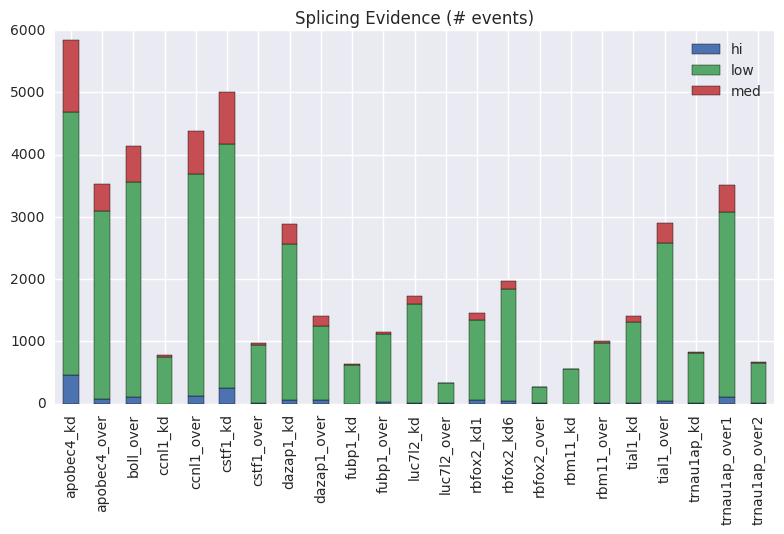

In [15]:
merged = {}
for condition in sorted(conditions):
    dfx = scores[condition]['included'].copy()
    dfy = scores[condition]['excluded'].copy()
    dfm = pd.concat([dfx, dfy])
    dfm.columns = ['Gene','path','event','name','notes','sepscore','qvalue']
    dfm['sepscore'] = abs(dfm['sepscore'])
    df_lo = dfm[
        (dfm['sepscore'] >= 0.5) & (dfm['sepscore'] < 1)
    ]
    df_med = dfm[
        (dfm['sepscore'] >= 1) & (dfm['sepscore'] < 1.5)
    ]
    df_hi = dfm[
        (dfm['sepscore'] >= 1.5)
    ]
    merged[condition] = {
        'low':df_lo.shape[0],
        'med':df_med.shape[0],
        'hi':df_hi.shape[0]
    }
merged = pd.DataFrame(merged).T
merged.plot(kind='bar',stacked=True)
plt.title('Splicing Evidence (# events)')
plt.tight_layout()